# Plotting ELU and SELU activation func and testing out their usage

## Importing libraries

In [56]:
import numpy as np
import pandas as pd
from scipy.special import erfc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

## ELU

In [2]:
z = np.linspace(-5, 5, 1000)

In [3]:
def elu(z, alpha = 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z) 

<AxesSubplot:>

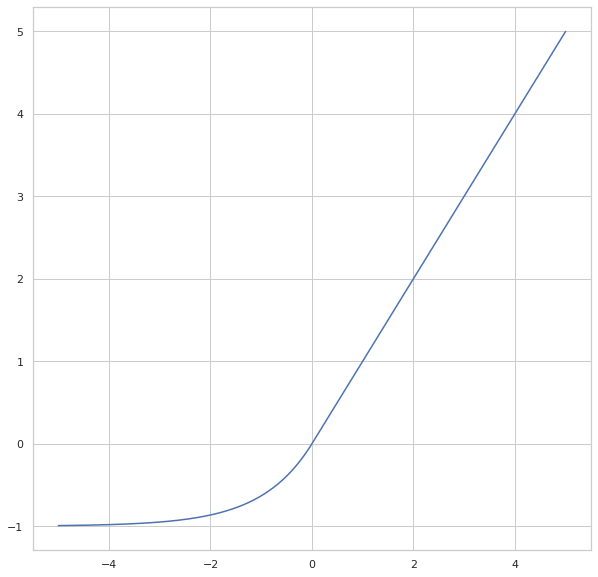

In [9]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10,10))
sns.lineplot(x = z, y = elu(z, alpha = 1))

## SELU

In [15]:
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)

In [16]:
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [17]:
def selu(z, scale = scale_0_1, alpha = alpha_0_1):
    return scale * elu(z, alpha)

<AxesSubplot:>

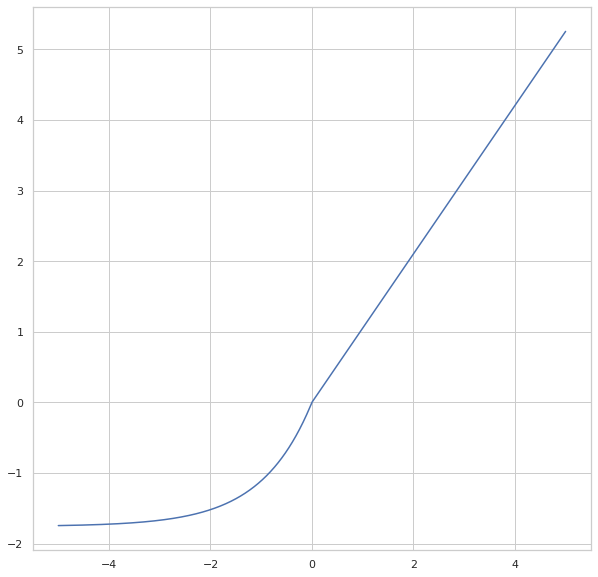

In [18]:
plt.figure(figsize = (10,10))
sns.lineplot(z, selu(z))

## Building a NN using SELU activation func. and training it on the Fashion MNIST data.

In [20]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [21]:
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255

In [32]:
x_train.shape

(55000, 28, 28)

In [42]:
x_valid.shape

(5000, 28, 28)

In [43]:
x_test.shape

(10000, 28, 28)

In [44]:
pixel_mean = x_train.mean(axis = 0, keepdims = True)
pixel_std = x_train.std(axis = 0, keepdims = True)

- For using SELU activation func. we need to make sure that the input to each layer must have mean 0 and SD 1.

In [51]:
x_train_scaled = (x_train - pixel_mean) / pixel_std
x_valid_scaled = (x_valid - pixel_mean) / pixel_std
x_test_scaled = (x_test - pixel_mean) / pixel_std

In [59]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [60]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [61]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [62]:
history = model.fit(x_train_scaled, y_train, epochs = 10, validation_data = (x_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 11ms/step - loss: 1.3334 - accuracy: 0.4839 - val_loss: 0.9025 - val_accuracy: 0.6378
Epoch 2/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.8163 - accuracy: 0.6995 - val_loss: 0.6984 - val_accuracy: 0.7604
Epoch 3/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.6562 - accuracy: 0.7606 - val_loss: 0.7473 - val_accuracy: 0.7196
Epoch 4/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5770 - accuracy: 0.7916 - val_loss: 0.5426 - val_accuracy: 0.8054
Epoch 5/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5453 - accuracy: 0.8068 - val_loss: 0.5137 - val_accuracy: 0.8240
Epoch 6/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4848 - accuracy: 0.8288 - val_loss: 0.4874 - val_accuracy: 0.8254
Epoch 7/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4731 - accuracy: 0.8347 - val_loss: 0.4456 -

In [63]:
df_metrics = pd.DataFrame(history.history)

<AxesSubplot:>

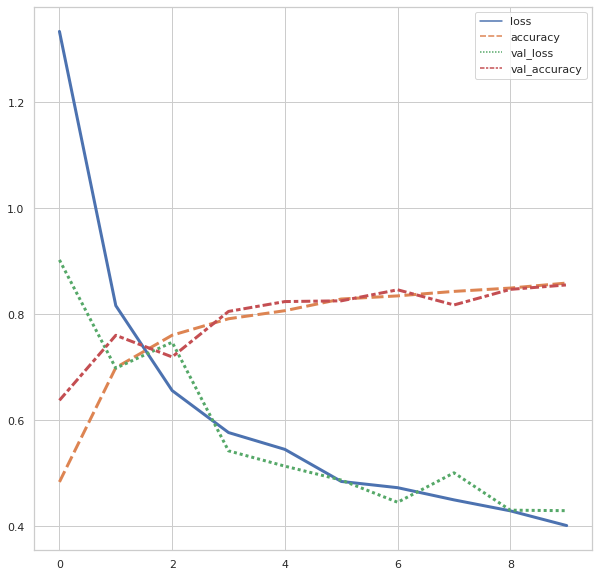

In [64]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics, linewidth = 3)

In [66]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4707 - accuracy: 0.8410


[0.47073110938072205, 0.8410000205039978]